In [1]:
# Import thư viện
import pandas as pd
import numpy as np
import datetime as dt
from google.colab import drive
drive.mount('/content/drive/')


# Đọc file transfer_menbership_transaction
trans = pd.read_csv('/content/drive/My Drive/TC-BI69-Group 2/Slide + Record/RFM + Churn + Cohort/transfer_membership_transaction.csv')


# Chuyển đổi kiểu dữ liệu cho cột
## membership_transaction_time -> datetime
trans['membership_transaction_time'] = pd.to_datetime(trans['membership_transaction_time'],format='mixed')
## product_purchase_time -> datetime
trans['product_purchase_time'] = pd.to_datetime(trans['product_purchase_time'],format='mixed')
## created_at -> datetime
trans['created_at'] = pd.to_datetime(trans['created_at'],format='mixed')
## modified_at -> datetime
trans['modified_at'] = pd.to_datetime(trans['modified_at'],format='mixed')


Mounted at /content/drive/


In [2]:
# Lọc ra những giao dịch bị CANCEL
trans['cancel_count'] = trans.sort_values(['membership_transaction_no','org_membership_transaction_no'],ascending=[True,False]).groupby(['user_id','org_membership_transaction_no']).cumcount()+1
demen_trans = trans.groupby(['user_id','org_membership_transaction_no'])['cancel_count'].max().reset_index()
result = pd.merge(trans,demen_trans,on=['org_membership_transaction_no','user_id'],how='inner',suffixes=('_x', '_y'))
final_result = result[result['cancel_count_y'] <= 1]
final_result

,Unnamed: 0,id,membership_transaction_no,org_membership_transaction_no,membership_transaction_time,user_id,membership_id,brand_id,shop_brand_name,branch,...,product_purchase_time,product_currency,product_amount,discount_amount,total_point_amount,created_at,modified_at,bill_amount,cancel_count_x,cancel_count_y
16,15,15,VN00001220220324020005,VN00001220220324020005,2022-03-24 07:01:14.000,24,3,8,LANEIGE,Ba Thang Hai,...,2022-03-24 07:01:14,VND,0,0.0,715.0,2022-03-24 07:02:00.149,2022-03-24 07:02:00.149,0,1,1
49,50,50,0100800130187220882R000020,0100800130187220882R000020,2022-03-29 07:11:34.047,15,1,2,Lotte Mart,LM Ba Dinh,...,2022-03-29 07:04:01,VND,0,0.0,250900.0,2022-03-29 07:11:35.481,2022-07-12 05:06:35.291,0,1,1
50,51,51,0100800130188220882R000021,0100800130188220882R000021,2022-03-29 07:12:11.263,17,1,2,Lotte Mart,LM Ba Dinh,...,2022-03-29 07:04:40,VND,0,0.0,250900.0,2022-03-29 07:12:12.026,2022-07-12 05:06:35.291,0,1,1
51,52,52,0100800130189220882R000022,0100800130189220882R000022,2022-03-29 07:12:44.013,16,1,2,Lotte Mart,LM Ba Dinh,...,2022-03-29 07:05:11,VND,0,0.0,250900.0,2022-03-29 07:12:44.841,2022-07-12 05:06:35.291,0,1,1
52,53,53,0100800130190220882R000023,0100800130190220882R000023,2022-03-29 07:13:23.933,15,1,2,Lotte Mart,LM Ba Dinh,...,2022-03-29 07:05:51,VND,0,0.0,235000.0,2022-03-29 07:13:23.941,2022-07-12 05:06:35.291,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4040840,4040841,4041347,10660200571110066560906,10660200571110066560906,2024-01-15 05:30:03.000,1196714,35,97,7-Eleven,Midtown M7-SH.31 D7,...,2024-01-15 05:29:57,VND,35000,0.0,668.0,2024-01-15 05:30:04.237,2024-01-15 05:30:04.237,35000,1,1
4040841,4040842,4041350,20240115TLJ010052010077E,20240115TLJ010052010077E,2024-01-15 05:28:15.000,2374833,2,7,Tous Les Jours,TLJ IPH (2) HN,...,2024-01-15 05:29:40,VND,123000,0.0,9720.0,2024-01-15 05:30:05.719,2024-01-15 05:30:05.719,123000,1,1
4040842,4040843,4041351,20240115TLJ010016010066R,20240115TLJ010016010066R,2024-01-15 05:28:35.000,473479,2,7,Tous Les Jours,TLJ HAU GIANG,...,2024-01-15 05:28:26,VND,112000,0.0,9540.0,2024-01-15 05:31:05.975,2024-01-15 05:31:05.975,97200,1,1
4040843,4040844,4041352,20240115TLJ010016010066E,20240115TLJ010016010066E,2024-01-15 05:28:35.000,473479,2,7,Tous Les Jours,TLJ HAU GIANG,...,2024-01-15 05:28:26,VND,112000,0.0,9540.0,2024-01-15 05:31:05.992,2024-01-15 05:31:05.992,97200,1,1


In [3]:
# Tính RFM
current_date = final_result['membership_transaction_time'].max()
## Tính Recency, Frequency, Monetary với mỗi customer_id
rfm_df = final_result.groupby('user_id').agg({
    'membership_transaction_time': lambda x: (current_date - pd.to_datetime(x).max()).days,  # Recency # Xem lại coi có cần group user_id để tìm ngày mua hàng gần nhất không??
    'membership_transaction_no': 'count',  # Frequency
    'point_amount': 'sum'  # Monetary
}).reset_index()
rfm_df.columns = ['user_id', 'Recency', 'Frequency', 'Monetary']

## Sắp xếp thứ tự cho 3 cột Recency, Frequency, Monetary
rfm_df['R_rank'] = rfm_df['Recency'].rank(pct=True)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(pct=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(pct=True)

In [4]:
## Phân tách giá trị ở mỗi cột và cho điểm
rfm_df['R_quartile'] = pd.cut(rfm_df['R_rank'], 5, labels=[5,4,3,2,1])
rfm_df['F_quartile'] = pd.cut(rfm_df['F_rank'], 5, labels=[1,2,3,4,5])
rfm_df['M_quartile'] = pd.cut(rfm_df['M_rank'], 5, labels=[1,2,3,4,5])

## Tính điểm RFM
rfm_df['RFM_Score'] = rfm_df['R_quartile'].astype(int)*100 + rfm_df['F_quartile'].astype(int)*10 + rfm_df['M_quartile'].astype(int)

## Bảng phân loại
segment_map = {
    'Champions': [555, 554, 544, 545, 454, 455, 445],
    'Loyal': [543, 444, 435, 355, 354, 345, 344, 335],
    'Potential Loyalist': [553, 551, 552, 541, 542, 533, 532, 531, 452, 451, 442, 441, 431, 453, 433, 432, 423, 353, 352, 351, 342, 341, 333, 323],
    'Promising': [525, 524, 523, 522, 521, 515, 514, 513, 425, 424, 413, 414, 415, 315, 314, 313],
    'New Customers': [512, 511, 422, 421, 412, 411, 311],
    'Need Attention': [535, 534, 443, 434, 343, 334, 325, 324],
    'About To Sleep': [331, 321, 312, 221, 213, 231, 241, 251],
    'At Risk': [255, 254, 245, 244, 253, 252, 243, 242, 235, 234, 225, 224, 153, 152, 145, 143, 142, 135, 134, 133, 125, 124],
    'Cannot Lose Them': [155, 154, 144, 214, 215, 115, 114, 113],
    'Hibernating customers': [332, 322, 233, 232, 223, 222, 132, 123, 122, 212, 211],
    'Lost customers': [111, 112, 121, 131, 141, 151]
}

## Function phân loại khách hàng dựa vào điểm RFM
def map_segment(score):
    for segment, scores in segment_map.items():
        if score in scores:
            return segment
    return 'Other'
## Phân loại khách hàng
rfm_df['Segment'] = rfm_df['RFM_Score'].apply(map_segment)

## Kiểm tra
rfm_df

,user_id,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,R_quartile,F_quartile,M_quartile,RFM_Score,Segment
0,3,640,2,2400.0,0.997775,0.758019,0.610953,1,4,4,144,Cannot Lose Them
1,5,550,2,2096.0,0.937477,0.758019,0.589041,1,4,3,143,At Risk
2,15,653,6,296020.0,0.999996,0.915239,0.978871,1,5,5,155,Cannot Lose Them
3,16,654,7,285620.0,0.999998,0.926446,0.978351,1,5,5,155,Cannot Lose Them
4,17,653,7,309520.0,0.999996,0.926446,0.979526,1,5,5,155,Cannot Lose Them
...,...,...,...,...,...,...,...,...,...,...,...,...
1187493,2504095,0,1,11000.0,0.001189,0.349487,0.813659,5,1,5,515,Promising
1187494,2504096,0,1,18.0,0.001189,0.349487,0.082380,5,1,1,511,New Customers
1187495,2504114,0,1,1520.0,0.001189,0.349487,0.204096,5,1,2,512,New Customers
1187496,2504118,0,1,2.0,0.001189,0.349487,0.043131,5,1,1,511,New Customers


**VẼ CHART BIỂU DIỄN**

In [5]:
# Import library
import matplotlib.pyplot as plt
import seaborn as sns

[Text(0, 0, '179972'),
 Text(0, 0, '84026'),
 Text(0, 0, '167539'),
 Text(0, 0, '157810'),
 Text(0, 0, '122888'),
 Text(0, 0, '82266'),
 Text(0, 0, '30268'),
 Text(0, 0, '7843'),
 Text(0, 0, '252475'),
 Text(0, 0, '25895'),
 Text(0, 0, '76516')]

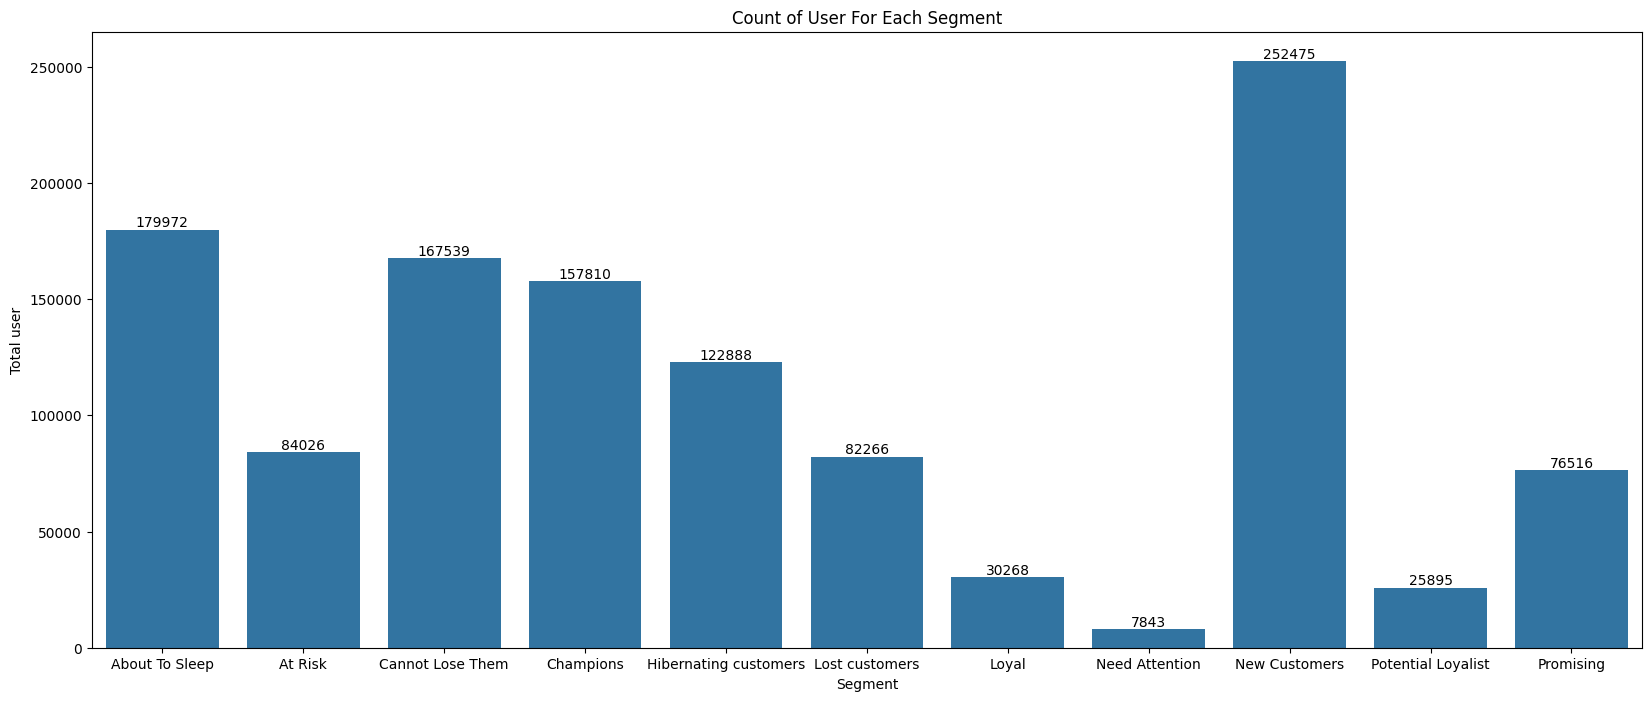

In [ ]:
# Tạo bảng đếm số lượng khách hàng với mỗi tệp khách hàng
segment_count = rfm_df.groupby('Segment').agg(Count = ('user_id','count')).reset_index()

# Vẽ chart thể hiện số lượng user ở mỗi tệp phân loại
plt.figure(figsize=(20,8))
plt.title('Count of User For Each Segment')
plt.xlabel('Segment')
plt.ylabel('Total user')
count_of_user = sns.barplot(data=segment_count, x = segment_count['Segment'], y = segment_count['Count'], errorbar = None)
count_of_user.bar_label(count_of_user.containers[0])

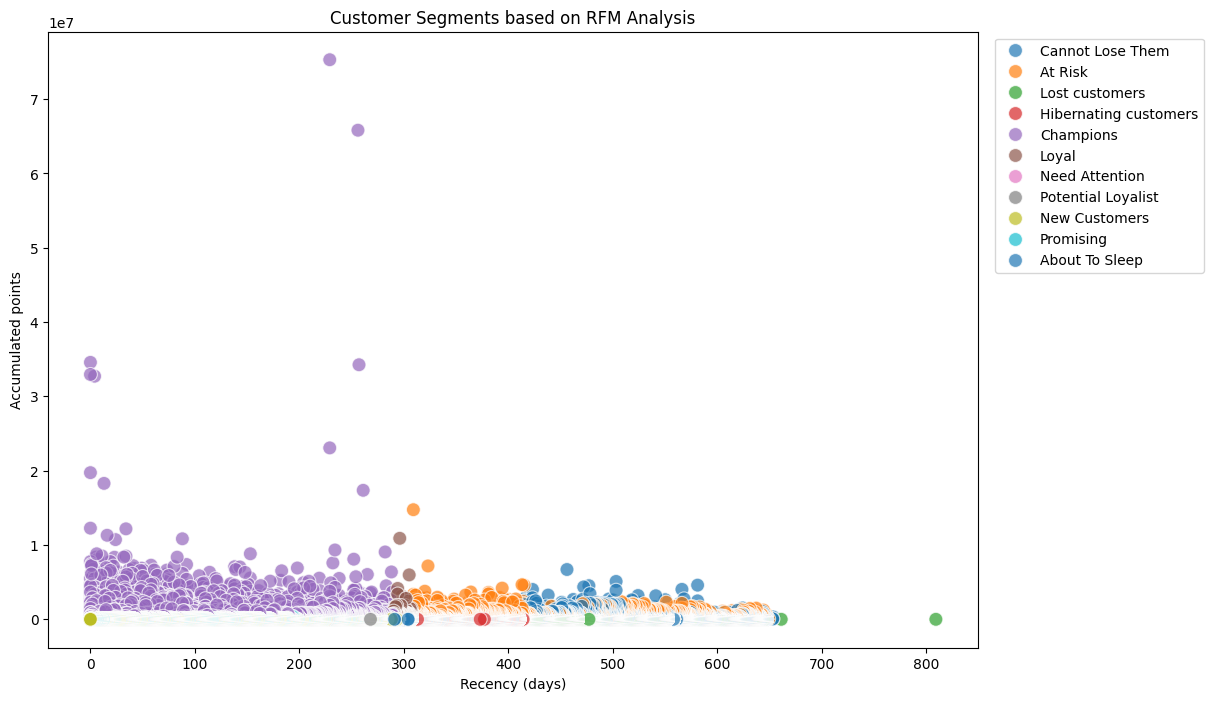

In [ ]:
# Vẽ chart thể hiện mối tương quan giữa Recency và Monetary
plt.figure(figsize=(12,8))
plt.title('Customer Segments based on RFM Analysis')
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary',hue='Segment', palette='tab10', s=100, alpha=0.7)
plt.xlabel('Recency (days)')
plt.ylabel('Accumulated points')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

**NHẬN XÉT:**

- Phần lớn các phân khúc khách hàng có giá trị về số điểm tích lũy không cao và có thời gian không sử dụng ứng dụng (tính đến thời điểm hiện tại) trải dài với giá trị dao động từ 0 đến dưới 700 ngày (gần 2 năm).
- Nhìn chung, những khách hàng nào có thời gian sử dụng ứng dụng gần nhất thì họ sẽ có điểm tích lũy trên ứng dụng cao hơn (điển hình là phân khúc khách hàng Champions).
- Những nhóm khách hàng trung thành như Champions, Loyal, At Risk có giá trị sử dụng dịch vụ cao và có thể dễ dàng nhận thấy. Điều này giúp công ty dễ dàng tập trung vào các chiến lược giữ chân và phát triển.

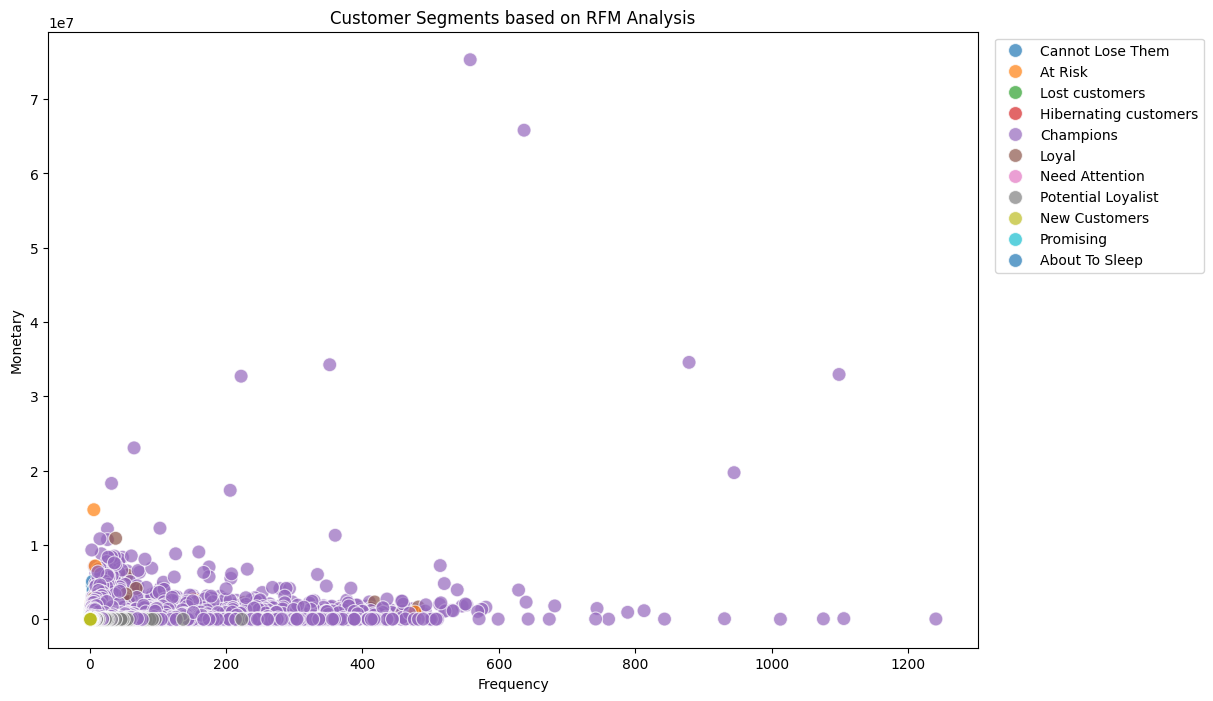

In [ ]:
# Vẽ chart thể hiện mối tương quan giữa Frequency và Monetary
plt.figure(figsize=(12,8))
plt.title('Customer Segments based on RFM Analysis')
sns.scatterplot(data=rfm_df, x='Frequency', y='Monetary',hue='Segment', palette='tab10', s=100, alpha=0.7)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

**NHẬN XÉT:**

- Tập trung phần lớn số điểm mà khách hàng tích được khi sử dụng ứng dụng đều ở mức thấp.
- Phân khúc khách hàng thuộc nhóm Champions có tần suất và mật độ sử dụng ứng dụng nhiều nhất.
- Có thể thấy được khi khách hàng họ gia tăng tần suất sử dụng thì số điểm mà họ tích được trên ứng dụng cũng không quá nhiều. Có thể các đối tác thương hiệu của Vani có quy để tích và sử dụng điểm khác nhau.

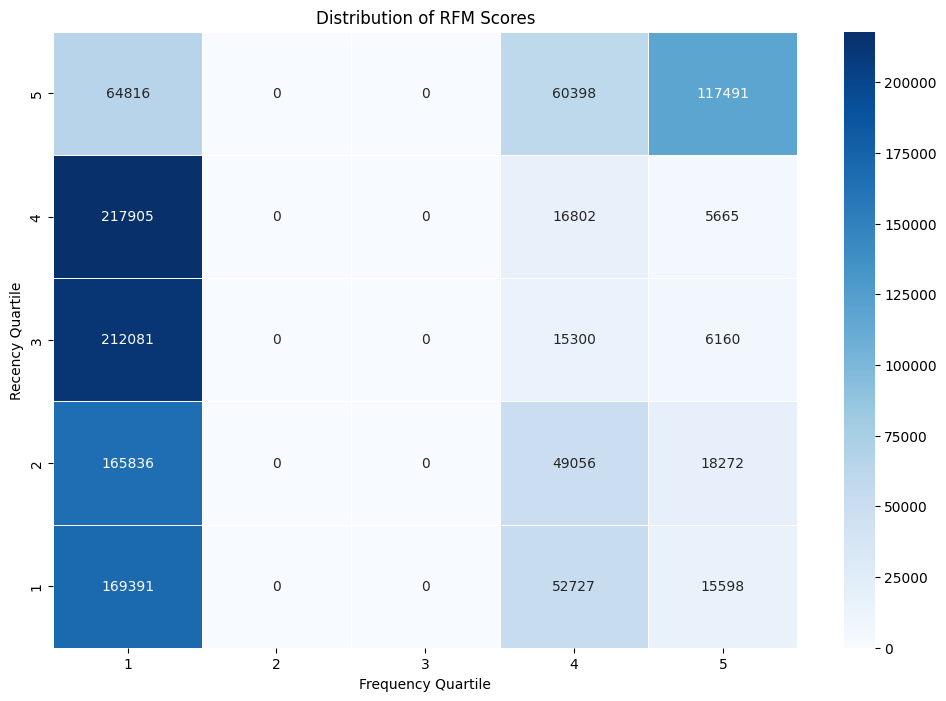

In [ ]:
# Vẽ chart phân phối điểm RFM
plt.figure(figsize=(12,8))
rfm_pivot = rfm_df.pivot_table(index='R_quartile',columns='F_quartile',values='M_quartile',aggfunc='count',fill_value=0)
sns.heatmap(rfm_pivot, cmap='Blues', annot=True, fmt='d', linewidths=.5)
plt.title('Distribution of RFM Scores')
plt.xlabel('Frequency Quartile')
plt.ylabel('Recency Quartile')
plt.show()

**NHẬN XÉT:**

- Phần lớn khách hàng có thời gian sử dụng ứng dụng khá gần với thời điểm hiện tại nhưng ngược lại họ có tần suất sử dụng ứng dụng không cao.
- Ngược lại với những khách hàng có tần suất sử dụng ứng dụng thường xuyên thì những khách hàng còn lại có lịch sử ghi nhận lần sử dụng ứng dụng cuối cùng cách thời điểm hiện tại khá lâu.

**TÍNH TOÁN MỘT VÀI CHỈ SỐ CHO MỖI TỆP KHÁCH HÀNG**

In [ ]:
# Tính số điểm trung bình của mỗi tệp khách hàng tích lũy được khi sử dụng ứng dụng
rfm_avg_point_amount = rfm_df.groupby('Segment').agg(Avg_point_amount = ('Monetary','mean')).reset_index().round(2)
rfm_avg_point_amount

,Segment,Avg_point_amount
0,About To Sleep,1502.59
1,At Risk,56344.30
2,Cannot Lose Them,18481.94
3,Champions,159082.99
4,Hibernating customers,1025.67
5,Lost customers,534.61
6,Loyal,35850.33
7,Need Attention,1649.02
8,New Customers,1168.17
9,Potential Loyalist,550.72


In [ ]:
# Tính số lần giao dịch trung bình của mỗi tệp khách hàng
rfm_avg_trans = rfm_df.groupby(['Segment']).agg(Avg_transaction = ('Frequency','mean')).reset_index().round(2)
rfm_avg_trans

,Segment,Avg_transaction
0,About To Sleep,1.07
1,At Risk,3.88
2,Cannot Lose Them,1.72
3,Champions,14.72
4,Hibernating customers,1.00
5,Lost customers,1.20
6,Loyal,5.85
7,Need Attention,2.10
8,New Customers,1.00
9,Potential Loyalist,5.56


<Axes: title={'center': 'Average Transaction & Average Point Amount by Customer Segments'}, xlabel='Segment', ylabel='Avg_point_amount'>

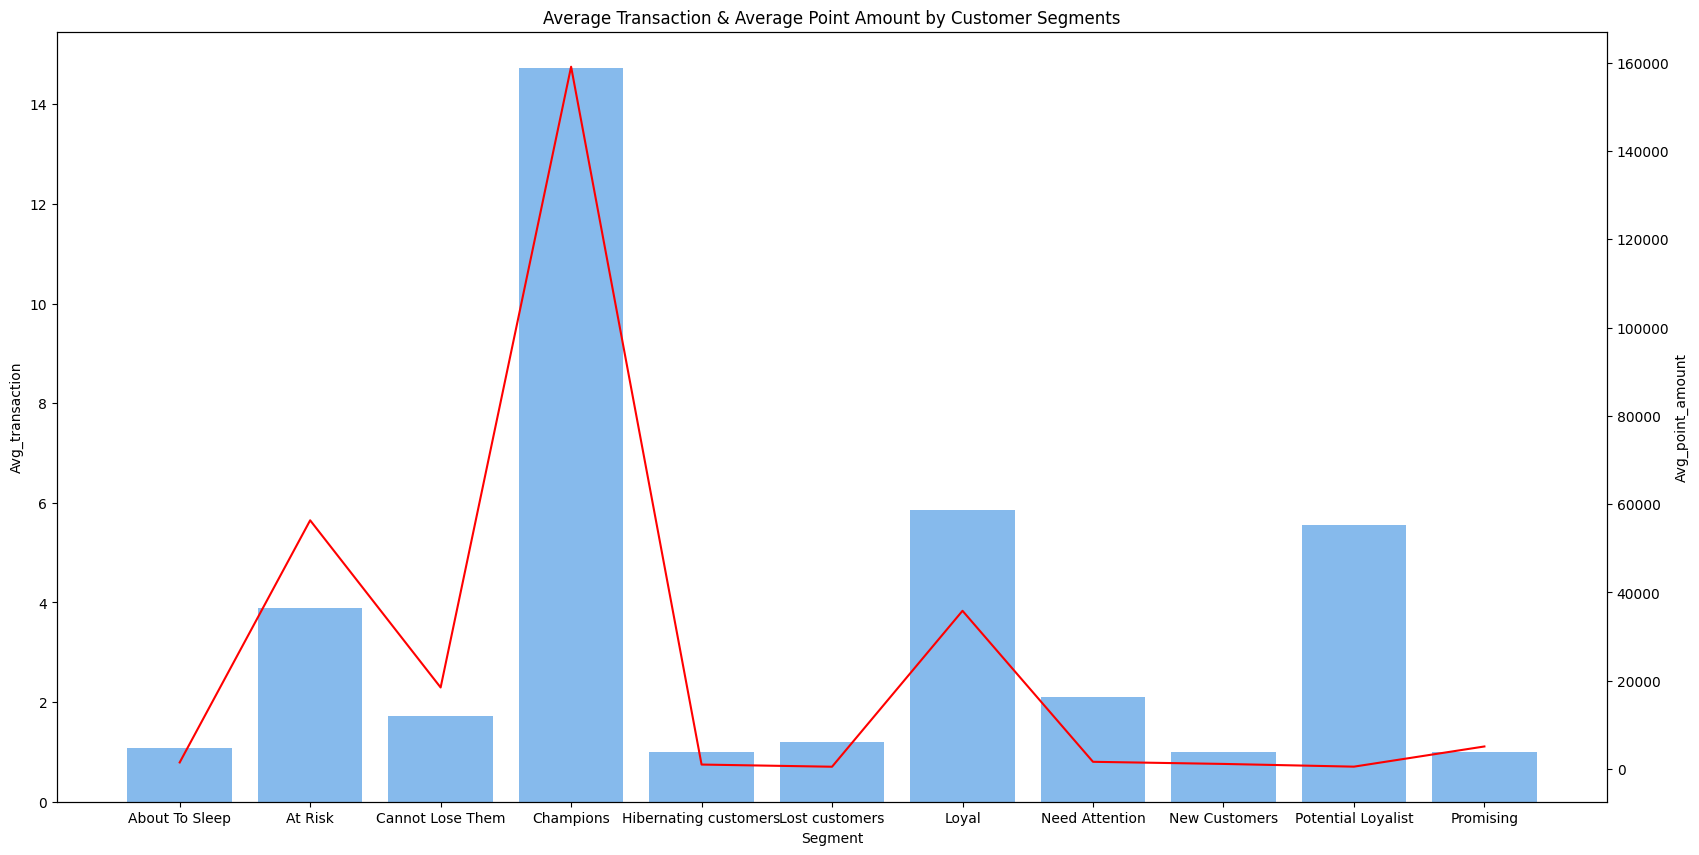

In [ ]:
# Vẽ chart biểu diễn
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()
plt.title('Average Transaction & Average Point Amount by Customer Segments')

sns.barplot(data=rfm_avg_trans, x='Segment', y='Avg_transaction', ax=ax1,color='xkcd:sky blue')
sns.lineplot(data=rfm_avg_point_amount, x='Segment', y='Avg_point_amount', ax=ax2,color='red')

##**COHORT ANALYSIS**


**Bước 1: Xác định độ nhuyễn của thời gian phân tích (dùng cột created_at)**

In [ ]:
# Tách tháng-năm ra khỏi cột created_at
final_result['Month'] = final_result['created_at'].dt.strftime('%Y-%m')

<ipython-input-17-fe481284985e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_result['Month'] = final_result['created_at'].dt.strftime('%Y-%m')


**Bước 2: Tìm mốc đầu tiên mà khách hàng phát sinh giao dịch**

In [ ]:
# Groupby người dùng và tìm thời điểm đầu tiên mà khách hàng phát sinh giao dịch
final_result['Cohort_month'] = final_result.groupby('user_id')['Month'].transform('min')

<ipython-input-6-6b275c1002dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_result['Cohort_month'] = final_result.groupby('user_id')['Month'].transform('min')


**Bước 3: Tính Cohort index**

In [ ]:
def cohort_index(data,col1,col2):
  current_year = pd.to_datetime(data['created_at']).dt.year
  current_month = pd.to_datetime(data['created_at']).dt.month
  cohort_year = pd.to_datetime(data['Cohort_month']).dt.year
  cohort_month = pd.to_datetime(data['Cohort_month']).dt.month
  return (current_year - cohort_year)*12 + current_month - cohort_month

final_result['Cohort_index'] = cohort_index(final_result,'created_at','Cohort_month')
final_result

<ipython-input-7-5f0c68ffaf8d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_result['Cohort_index'] = cohort_index(final_result,'created_at','Cohort_month')


,Unnamed: 0,id,membership_transaction_no,org_membership_transaction_no,membership_transaction_time,user_id,membership_id,brand_id,shop_brand_name,branch,...,discount_amount,total_point_amount,created_at,modified_at,bill_amount,cancel_count_x,cancel_count_y,Month,Cohort_month,Cohort_index
16,15,15,VN00001220220324020005,VN00001220220324020005,2022-03-24 07:01:14.000,24,3,8,LANEIGE,Ba Thang Hai,...,0.0,715.0,2022-03-24 07:02:00.149,2022-03-24 07:02:00.149,0,1,1,2022-03,2022-03,0
49,50,50,0100800130187220882R000020,0100800130187220882R000020,2022-03-29 07:11:34.047,15,1,2,Lotte Mart,LM Ba Dinh,...,0.0,250900.0,2022-03-29 07:11:35.481,2022-07-12 05:06:35.291,0,1,1,2022-03,2022-03,0
50,51,51,0100800130188220882R000021,0100800130188220882R000021,2022-03-29 07:12:11.263,17,1,2,Lotte Mart,LM Ba Dinh,...,0.0,250900.0,2022-03-29 07:12:12.026,2022-07-12 05:06:35.291,0,1,1,2022-03,2022-03,0
51,52,52,0100800130189220882R000022,0100800130189220882R000022,2022-03-29 07:12:44.013,16,1,2,Lotte Mart,LM Ba Dinh,...,0.0,250900.0,2022-03-29 07:12:44.841,2022-07-12 05:06:35.291,0,1,1,2022-03,2022-03,0
52,53,53,0100800130190220882R000023,0100800130190220882R000023,2022-03-29 07:13:23.933,15,1,2,Lotte Mart,LM Ba Dinh,...,0.0,235000.0,2022-03-29 07:13:23.941,2022-07-12 05:06:35.291,0,1,1,2022-03,2022-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4040840,4040841,4041347,10660200571110066560906,10660200571110066560906,2024-01-15 05:30:03.000,1196714,35,97,7-Eleven,Midtown M7-SH.31 D7,...,0.0,668.0,2024-01-15 05:30:04.237,2024-01-15 05:30:04.237,35000,1,1,2024-01,2022-09,16
4040841,4040842,4041350,20240115TLJ010052010077E,20240115TLJ010052010077E,2024-01-15 05:28:15.000,2374833,2,7,Tous Les Jours,TLJ IPH (2) HN,...,0.0,9720.0,2024-01-15 05:30:05.719,2024-01-15 05:30:05.719,123000,1,1,2024-01,2023-04,9
4040842,4040843,4041351,20240115TLJ010016010066R,20240115TLJ010016010066R,2024-01-15 05:28:35.000,473479,2,7,Tous Les Jours,TLJ HAU GIANG,...,0.0,9540.0,2024-01-15 05:31:05.975,2024-01-15 05:31:05.975,97200,1,1,2024-01,2022-06,19
4040843,4040844,4041352,20240115TLJ010016010066E,20240115TLJ010016010066E,2024-01-15 05:28:35.000,473479,2,7,Tous Les Jours,TLJ HAU GIANG,...,0.0,9540.0,2024-01-15 05:31:05.992,2024-01-15 05:31:05.992,97200,1,1,2024-01,2022-06,19


**Check point**

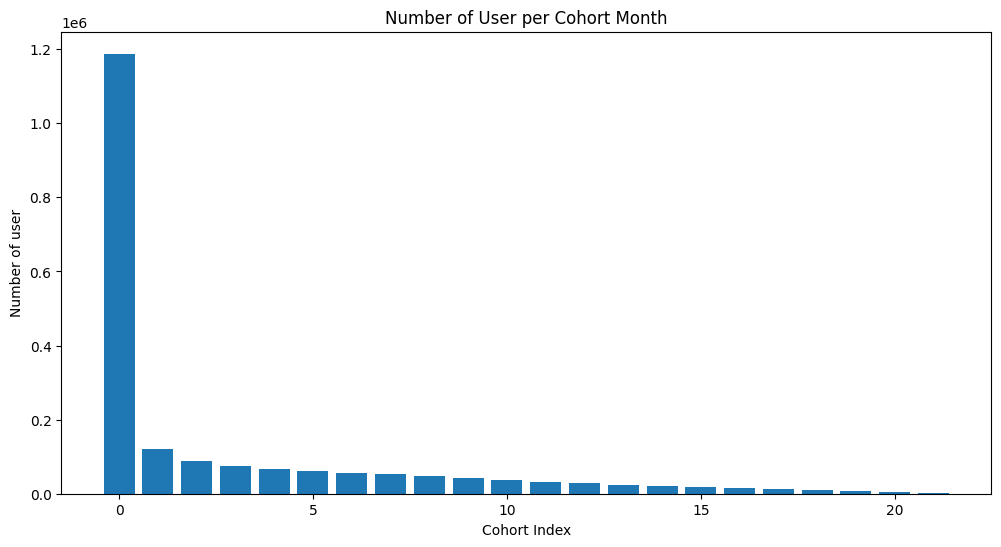

In [ ]:
import matplotlib.pyplot as plt
# Tính số lượng khách hàng ở mỗi cohort index
cohort_counts = final_result.groupby('Cohort_index')['user_id'].nunique()

# Tạo chart
plt.figure(figsize=(12,6))
plt.bar(cohort_counts.index,cohort_counts.values)
plt.xlabel('Cohort Index')
plt.ylabel('Number of user')
plt.title('Number of User per Cohort Month')
plt.show()

**Bước 4: Tính Cohort size**

In [ ]:
cohort_size = final_result.groupby(['Cohort_index','Cohort_month'])['user_id'].nunique().reset_index()
cohort_size

,Cohort_index,Cohort_month,user_id
0,0,2022-03,6
1,0,2022-04,29304
2,0,2022-05,46940
3,0,2022-06,48469
4,0,2022-07,34899
...,...,...,...
250,19,2022-05,3505
251,19,2022-06,1553
252,20,2022-04,3290
253,20,2022-05,1815


**Bước 5: Tính Retention rate**

In [ ]:
cohort_size['Retention_rate'] = cohort_size['user_id']/cohort_size.groupby('Cohort_month')['user_id'].transform('max')
cohort_size

,Cohort_index,Cohort_month,user_id,Retention_rate
0,0,2022-03,6,1.000000
1,0,2022-04,29304,1.000000
2,0,2022-05,46940,1.000000
3,0,2022-06,48469,1.000000
4,0,2022-07,34899,1.000000
...,...,...,...,...
250,19,2022-05,3505,0.074670
251,19,2022-06,1553,0.032041
252,20,2022-04,3290,0.112271
253,20,2022-05,1815,0.038666


In [ ]:
cohort_pivot = cohort_size.pivot_table(index='Cohort_month',columns='Cohort_index',values='Retention_rate')
cohort_pivot

Cohort_index,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
Cohort_month,,,,,,,,,,,,,,,,,,,,,
2022-03,1.0,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04,1.0,0.264264,0.200860,0.202259,0.183900,0.183832,0.193182,0.174072,0.173833,0.159057,...,0.160524,0.138684,0.112510,0.113329,0.106675,0.105310,0.103092,0.110497,0.112271,0.060947
2022-05,1.0,0.184874,0.243992,0.152258,0.149510,0.161440,0.143950,0.140903,0.128206,0.118598,...,0.104239,0.078441,0.079378,0.072816,0.071389,0.071304,0.075543,0.074670,0.038666,NaN
2022-06,1.0,0.242526,0.149250,0.143411,0.147104,0.130393,0.131631,0.120861,0.109410,0.135798,...,0.068002,0.064763,0.060740,0.058016,0.059172,0.062782,0.061813,0.032041,NaN,NaN
2022-07,1.0,0.173558,0.142354,0.137884,0.122296,0.114531,0.112238,0.101178,0.124502,0.110462,...,0.053784,0.051119,0.047050,0.048540,0.054271,0.052265,0.027164,NaN,NaN,NaN
2022-08,1.0,0.179473,0.156162,0.136369,0.127212,0.118162,0.110098,0.129592,0.115889,0.086187,...,0.061504,0.054599,0.054963,0.060796,0.059231,0.030902,NaN,NaN,NaN,NaN
2022-09,1.0,0.172790,0.120793,0.118798,0.100952,0.092728,0.115591,0.101096,0.074881,0.050969,...,0.046981,0.046199,0.050887,0.050044,0.024734,NaN,NaN,NaN,NaN,NaN
2022-10,1.0,0.152963,0.128796,0.104456,0.098946,0.120423,0.104065,0.080202,0.059181,0.055753,...,0.055775,0.058465,0.055840,0.028202,NaN,NaN,NaN,NaN,NaN,NaN
2022-11,1.0,0.116979,0.085038,0.074859,0.092620,0.081160,0.054346,0.036867,0.036132,0.033943,...,0.038696,0.034537,0.017573,NaN,NaN,NaN,NaN,NaN,NaN,NaN


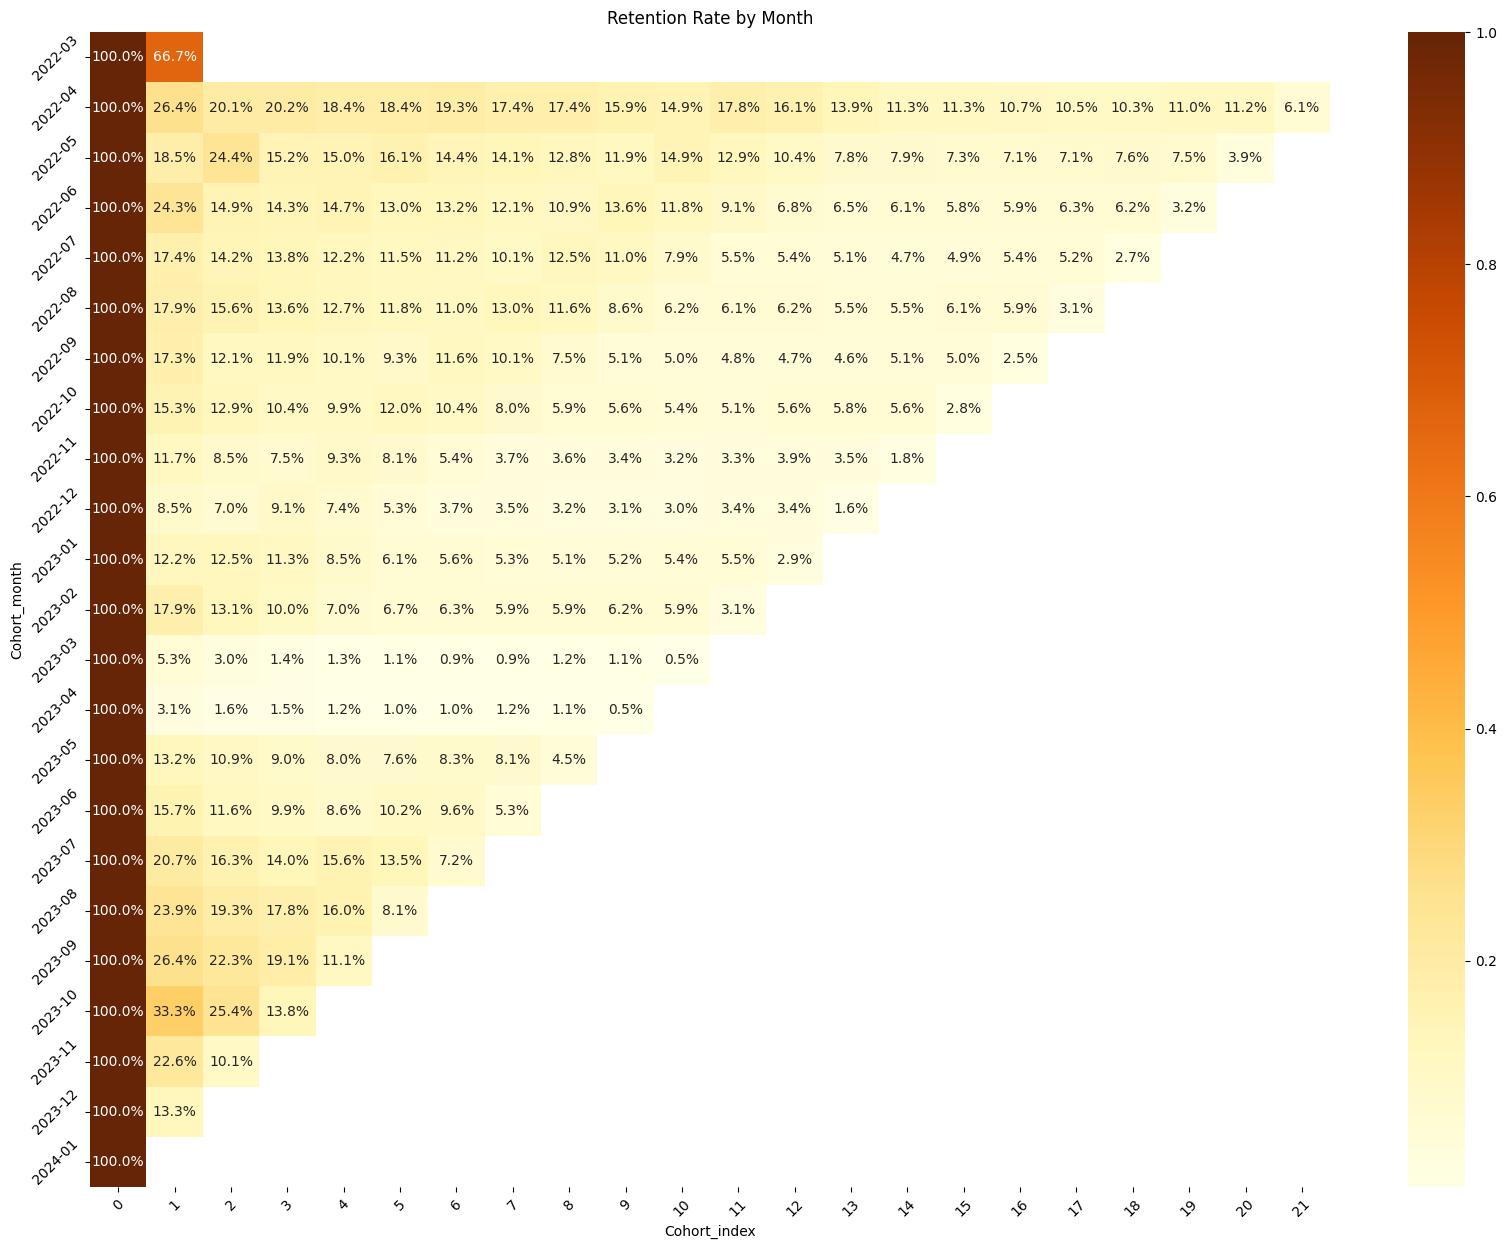

In [ ]:
# Vẽ chart
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(data = cohort_pivot,annot=True,fmt='.1%',cmap='YlOrBr',ax=ax)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Retention Rate by Month')
plt.show()

**NHẬN XÉT CHUNG CHO PHẦN PHÂN TÍCH COHORT:**

- Nhìn chung, so với thời điểm khách hàng mua hàng lần đầu tiên thì hầu hết ta nhận thấy sự sụt giảm đáng kể tỷ lệ giữ chân khách hàng ở tháng hoạt động tiếp theo, mức giảm trung bình được ước tính khoảng 80%.

=> Vào tháng sử dụng tiếp theo đánh dấu thời điểm mà khách hàng quyết định rời bỏ dịch vụ.

=> Ứng dụng tích điểm này đã thành công trong việc thu hút khách hàng mới sử dụng, nhưng lại chưa hiệu quả trong việc duy trì sự gắn bó của họ trong tháng tiếp theo.
+ Trong đó, ta ghi nhận sự sụt giảm mạnh số lượng khách hàng sử dụng ứng dụng này tại thời điểm tháng 3 và tháng 4 năm 2023 (mức giảm trung bình khoảng 96%).

**PHÂN TÍCH NGUYÊN NHÂN GÂY RA SỰ GIẢM SÚT TỶ LỆ GIỮ CHÂN KHÁCH HÀNG TRONG HAI THÁNG LIÊN TIẾP (THÁNG 3 - 4 - 5 NĂM 2023)**

In [ ]:
# Lọc ra tất cả thông tin khách hàng đã giao dịch trong tháng 3, tháng 4 năm 2023
df_tem = final_result[['user_id','Month','membership_id','shop_brand_name','point_amount','payment_method','traffic_type','product_amount','discount_amount','total_point_amount']]
df_cohort_analy = df_tem[df_tem['Month'].isin(['2023-03','2023-04','2023-05'])]
df_cohort_analy

,user_id,Month,membership_id,shop_brand_name,point_amount,payment_method,traffic_type,product_amount,discount_amount,total_point_amount
1351013,969884,2023-04,41,SPICY BOX,1.0,CASH,OFFLINE,141900,36364.0,1.0
1351729,2191097,2023-04,41,SPICY BOX,1.0,CASH,OFFLINE,141900,36364.0,1.0
1351823,2084461,2023-04,38,Dealtoday,0.0,E-WALLET,ONLINE,60000,0.0,0.0
1352137,2082445,2023-04,38,Dealtoday,0.0,E-WALLET,ONLINE,100000,0.0,0.0
1352512,2084526,2023-04,38,Dealtoday,0.0,E-WALLET,ONLINE,100000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3092904,2408755,2023-05,35,7-Eleven,20.0,E-WALLET,OFFLINE,20000,0.0,378.0
3092905,357045,2023-05,2,Tous Les Jours,2300.0,CASH,OFFLINE,117000,0.0,3100.0
3092906,8243,2023-05,2,Tous Les Jours,2500.0,CASH,OFFLINE,124000,0.0,19800.0
3092907,2401909,2023-05,35,7-Eleven,12.0,CASH,OFFLINE,12000,0.0,1759.0


In [ ]:
# Lọc ra những brand có hơn 10000 user sử dụng trong 3 tháng
brand = df_cohort_analy.groupby(['shop_brand_name']).agg(Total_user = ('user_id','count'),Using_month = ('Month','nunique')).reset_index().sort_values(by=['Total_user'],ascending=False)
top_brand = brand[brand['Total_user'] > 10000]
top_brand

,shop_brand_name,Total_user,Using_month
808,Dookki,522424,3
953,Tous Les Jours,247714,3
872,Lotte Mart,116730,3
845,INNISFREE,84322,3
921,SPICY BOX,50310,3
870,Lotte Cinema,34706,3
848,K-MARKET,28625,3
653,7-Eleven,22133,3
806,Dealtoday,22122,3
945,TOCOTOCOTEA,14978,3


In [ ]:
# Chuyển đổi sao cho chung kiểu dữ liệu của 2 cột được merge
df_cohort_analy['shop_brand_name'] = df_cohort_analy['shop_brand_name'].astype(str)
top_brand['shop_brand_name'] = top_brand['shop_brand_name'].astype(str)

# Merge bảng
df_merge = pd.merge(top_brand,df_cohort_analy,how='inner',on='shop_brand_name')[['shop_brand_name','Month','user_id','point_amount','product_amount','discount_amount']]
df_merge

<ipython-input-89-ce43da1115ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cohort_analy['shop_brand_name'] = df_cohort_analy['shop_brand_name'].astype(str)
<ipython-input-89-ce43da1115ce>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_brand['shop_brand_name'] = top_brand['shop_brand_name'].astype(str)


,shop_brand_name,Month,user_id,point_amount,product_amount,discount_amount
0,Dookki,2023-03,1138801,1529.0,152900,0.0
1,Dookki,2023-03,1138801,1309.0,152900,20000.0
2,Dookki,2023-03,1367446,1529.0,152900,0.0
3,Dookki,2023-03,1367446,1529.0,152900,0.0
4,Dookki,2023-03,1708699,3058.0,305800,0.0
...,...,...,...,...,...,...
1154333,Lotteria,2023-05,190463,18000.0,0,0.0
1154334,Lotteria,2023-05,190463,20.0,0,0.0
1154335,Lotteria,2023-05,136104,73000.0,0,0.0
1154336,Lotteria,2023-05,136104,260.0,0,0.0


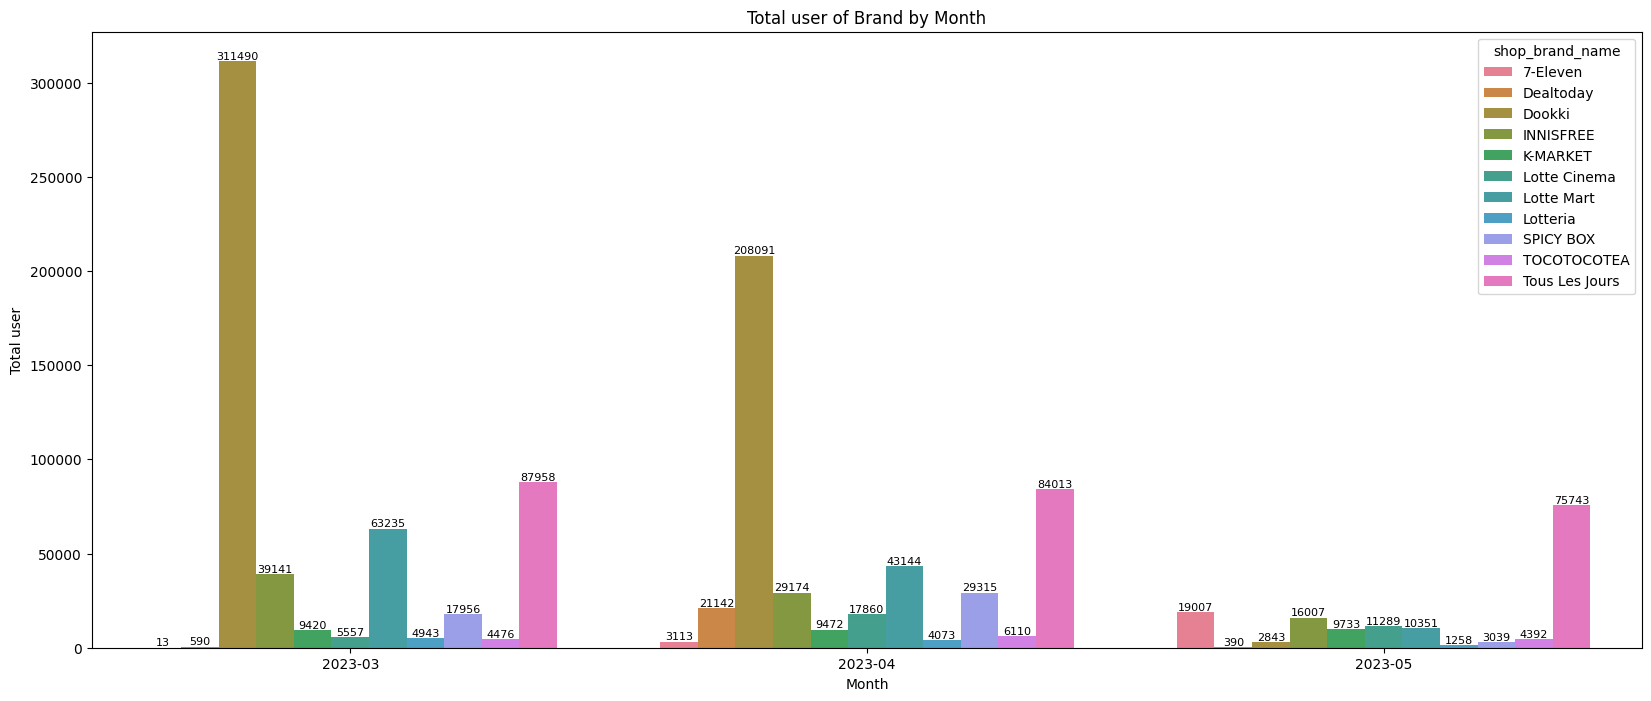

In [ ]:
# Làm bảng vẽ chart
gen = df_merge.groupby(['shop_brand_name','Month']).agg(Total_user = ('user_id','count'),
                                            Sum_point_amount = ('point_amount','sum'),
                                            Total_product_amount = ('product_amount','sum'),
                                            Total_dis_amount = ('discount_amount','sum')).reset_index()
# Cần import thư viên Matplotlib và Seaborn
# Vẽ chart
plt.figure(figsize=(20,8))
plt.title('Total user of Brand by Month')
plt.xlabel('Month')
plt.ylabel('Total user')
ax = sns.barplot(data=gen, x='Month',y='Total_user',hue='shop_brand_name',width=0.8)
for container in ax.containers:
  ax.bar_label(container,fontsize=8)

**NHẬN XÉT:**

- Ta nhận thấy, mức độ sụt giảm rõ rệt nhất trong số lượng người dùng Vani để tích điểm khi sử dụng dịch vụ ở thương hiệu Dooki trong 3 tháng. Và đây cũng là nguyên nhân chính khiến cho tỷ lệ giữ chân khách hàng giảm mạnh ở thời điểm tháng 03/2024 là 5.3% và tháng 04/2024 là 3.1%.
- Ngược lại với Dooki, Tour Les Jours duy giữ chân được số lượng người dùng ứng dụng khi mua hàng khá tốt khi thương hiệu ghi nhận tỷ lệ sụt giảm không đáng kể.

##**CHURN ANALYSIS**

In [ ]:
# Đánh số thứ tự cho dòng
final_result['row_num'] = final_result.sort_values('created_at').groupby('user_id').cumcount()+1

# Xác định đâu là khách hàng mới và đâu là khách hàng quay lại
final_result['user_status'] = final_result['row_num'].apply(lambda x : 'New customer' if x == 1 else 'Returned customer' )

# Tạo ra dataframe cần thiết để sử dụng
churn_data = final_result[['user_id','created_at','user_status']]
churn_data

<ipython-input-14-d7c350dd8913>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_result['row_num'] = final_result.sort_values('created_at').groupby('user_id').cumcount()+1
<ipython-input-14-d7c350dd8913>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_result['user_status'] = final_result['row_num'].apply(lambda x : 'New customer' if x == 1 else 'Returned customer' )


,user_id,created_at,user_status
16,24,2022-03-24 07:02:00.149,New customer
49,15,2022-03-29 07:11:35.481,New customer
50,17,2022-03-29 07:12:12.026,New customer
51,16,2022-03-29 07:12:44.841,New customer
52,15,2022-03-29 07:13:23.941,Returned customer
...,...,...,...
4040840,1196714,2024-01-15 05:30:04.237,Returned customer
4040841,2374833,2024-01-15 05:30:05.719,Returned customer
4040842,473479,2024-01-15 05:31:05.975,Returned customer
4040843,473479,2024-01-15 05:31:05.992,Returned customer


In [ ]:
# Tạo cột tháng trong năm
churn_data['month'] = churn_data['created_at'].dt.strftime('%Y-%m')

# Tạo bảng tính Retention Rate
churn_data_pivot = churn_data.pivot_table(index='month', columns='user_status', values='user_id',aggfunc='count', fill_value=0).reset_index()
churn_data_pivot

<ipython-input-17-3c35a4e8162e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_data['month'] = churn_data['created_at'].dt.strftime('%Y-%m')


user_status,month,New customer,Returned customer
0,2022-03,6,16
1,2022-04,29304,10479
2,2022-05,46940,40783
3,2022-06,48469,67114
4,2022-07,34899,98917
5,2022-08,46631,116408
6,2022-09,48637,139883
7,2022-10,46096,157056
8,2022-11,63960,164238
9,2022-12,78340,183288


In [ ]:
# Tính Accumulate user
## Tạo cột Accumulate user
churn_data_pivot['Accumulate user'] = [0]*len(churn_data_pivot['month'])
for i in range(len(churn_data_pivot['month'])):
  if i == 0:
    churn_data_pivot.iloc[i,3] = churn_data_pivot.iloc[i,1] + churn_data_pivot.iloc[i,2]
  else:
    x = churn_data_pivot['Accumulate user'].shift(1)[i]
    churn_data_pivot.iloc[i,3] = churn_data_pivot.iloc[i,1] + churn_data_pivot.iloc[i,2] + x

## Kiểm tra bảng
churn_data_pivot


user_status,month,New customer,Returned customer,Accumulate user
0,2022-03,6,16,22
1,2022-04,29304,10479,39805
2,2022-05,46940,40783,127528
3,2022-06,48469,67114,243111
4,2022-07,34899,98917,376927
5,2022-08,46631,116408,539966
6,2022-09,48637,139883,728486
7,2022-10,46096,157056,931638
8,2022-11,63960,164238,1159836
9,2022-12,78340,183288,1421464


In [ ]:
# Tạo cột Accumulate user đầu kỳ
churn_data_pivot['Pre Accumulate user'] = churn_data_pivot['Accumulate user'].shift(1)

# Chỉnh giá trị NULL ở tháng đầu tiên thành 0
churn_data_pivot['Pre Accumulate user'].fillna(value=0, inplace=True)

# Tính Retention rate
churn_data_pivot['Retention rate'] = ((churn_data_pivot['Pre Accumulate user'] - churn_data_pivot['New customer'])/churn_data_pivot['Accumulate user']*100).round(2)

# Tính Churn rate
churn_data_pivot['Churn rate'] = (100 - churn_data_pivot['Retention rate']).round(2)

# Kiểm tra bảng
churn_data_pivot

user_status,month,New customer,Returned customer,Accumulate user,Pre Accumulate user,Retention rate,Churn rate
0,2022-03,6,16,22,0.0,-27.27,127.27
1,2022-04,29304,10479,39805,22.0,-73.56,173.56
2,2022-05,46940,40783,127528,39805.0,-5.59,105.59
3,2022-06,48469,67114,243111,127528.0,32.52,67.48
4,2022-07,34899,98917,376927,243111.0,55.24,44.76
5,2022-08,46631,116408,539966,376927.0,61.17,38.83
6,2022-09,48637,139883,728486,539966.0,67.45,32.55
7,2022-10,46096,157056,931638,728486.0,73.25,26.75
8,2022-11,63960,164238,1159836,931638.0,74.81,25.19
9,2022-12,78340,183288,1421464,1159836.0,76.08,23.92


**VẼ CHART BIỂU DIỄN CHO BẢNG KẾT QUẢ VỪA TÍNH**

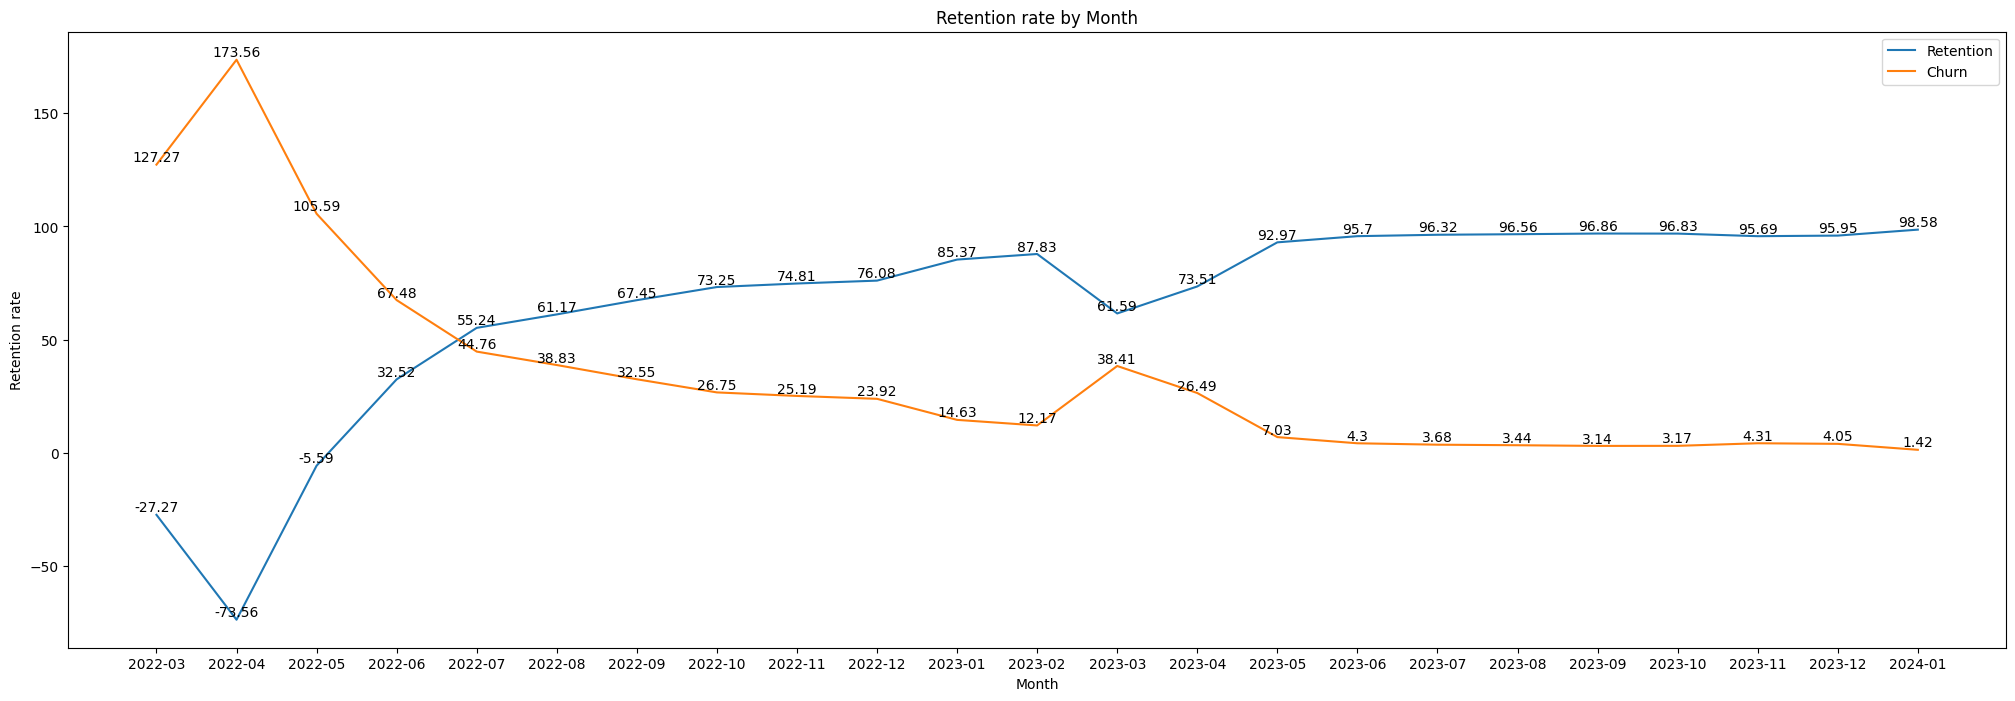

In [ ]:
# Vẽ line chart cho bảng churn_data_pivot
plt.figure(figsize=(25,8))
sns.lineplot(data=churn_data_pivot, x='month', y='Retention rate',label='Retention', markers='o')
sns.lineplot(data=churn_data_pivot, x='month', y='Churn rate',label='Churn', markers='s')
plt.title('Retention rate by Month')
plt.xlabel('Month')
plt.ylabel('Retention rate')
for i in range(churn_data_pivot.shape[0]):
  plt.text(churn_data_pivot['month'][i], churn_data_pivot['Retention rate'][i], str(churn_data_pivot['Retention rate'][i]), ha='center', va='bottom')
  plt.text(churn_data_pivot['month'][i], churn_data_pivot['Churn rate'][i], str(churn_data_pivot['Churn rate'][i]), ha='center', va='bottom')

# Show chart
plt.show()

**NHẬN XÉT**:

- Tỷ lệ giữ chân khách hàng trong suốt thời gian ghi nhận dự liệu có sự tăng trưởng đáng kể

#**LIÊN KẾT RFM VÀ CHURN ĐỂ PHÂN TÍCH VÀ KHẮC HỌA CHÂN DUNG KHÁCH HÀNG:**

In [6]:
# Tạo function để tính tỷ lệ rời bỏ của 3 phân khúc có số lượng khách hàng lớn nhất (ngoại trừ New Customers)
new_customer_churn = final_result.merge(rfm_df[rfm_df['Segment']=='New Customers'], on='user_id')
def segment_churn(new_customer_churn):
  new_customer_churn['row_num'] = new_customer_churn.sort_values('created_at').groupby('user_id').cumcount()+1
  # Xác định đâu là khách hàng mới và đâu là khách hàng quay lại
  new_customer_churn['user_status'] = new_customer_churn['row_num'].apply(lambda x : 'New customer' if x == 1 else 'Returned customer')

  # Tạo ra dataframe cần thiết để sử dụng
  churn_data = new_customer_churn[['user_id','created_at','user_status']]

  # Tạo cột tháng trong năm
  churn_data['month'] = churn_data['created_at'].dt.strftime('%Y-%m')

  # Tạo bảng tính Retention Rate
  churn_data_pivot = churn_data.pivot_table(index='month', columns='user_status', values='user_id',aggfunc='count', fill_value=0).reset_index()

  # Tính Accumulate user
  ## Tạo cột Accumulate user
  churn_data_pivot['Accumulate user'] = [0]*len(churn_data_pivot['month'])
  for i in range(len(churn_data_pivot['month'])):
    if i == 0:
      churn_data_pivot.iloc[i,3] = churn_data_pivot.iloc[i,1] + churn_data_pivot.iloc[i,2]
    else:
      x = churn_data_pivot['Accumulate user'].shift(1)[i]
      churn_data_pivot.iloc[i,3] = churn_data_pivot.iloc[i,1] + churn_data_pivot.iloc[i,2] + x

  # Tạo cột Accumulate user đầu kỳ
  churn_data_pivot['Pre Accumulate user'] = churn_data_pivot['Accumulate user'].shift(1)

  # Chỉnh giá trị NULL ở tháng đầu tiên thành 0
  churn_data_pivot['Pre Accumulate user'].fillna(value=0, inplace=True)

  # Tính Retention rate
  churn_data_pivot['Retention rate'] = ((churn_data_pivot['Pre Accumulate user'] - churn_data_pivot['New customer'])/churn_data_pivot['Accumulate user']*100).round(2)

  # Tính Churn rate
  churn_data_pivot['Churn rate'] = (100 - churn_data_pivot['Retention rate']).round(2)

  return churn_data_pivot

In [7]:
# Lọc ra khách hàng thuộc phân khúc Champions
champion_churn = final_result.merge(rfm_df[rfm_df['Segment']=='Champions'], on='user_id')
# Thực hiện function với phân khúc Champion  Cannot Lose Them
champion_churn = segment_churn(champion_churn)

<ipython-input-6-a7249d9d2878>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_data['month'] = churn_data['created_at'].dt.strftime('%Y-%m')


In [8]:
# Lọc ra khách hàng thuộc phân khúc Cannot Lose Them
cannot_lose_churn = final_result.merge(rfm_df[rfm_df['Segment']=='Cannot Lose Them'], on='user_id')
# Thực hiện function với phân khúc Champion
cannot_lose_churn = segment_churn(cannot_lose_churn)

<ipython-input-6-a7249d9d2878>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_data['month'] = churn_data['created_at'].dt.strftime('%Y-%m')


In [9]:
# Lọc ra khách hàng thuộc phân khúc About To Sleep
about_to_sleep_churn = final_result.merge(rfm_df[rfm_df['Segment']=='About To Sleep'], on='user_id')
# Thực hiện function với phân khúc Champion
about_to_sleep_churn = segment_churn(about_to_sleep_churn)

<ipython-input-6-a7249d9d2878>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_data['month'] = churn_data['created_at'].dt.strftime('%Y-%m')


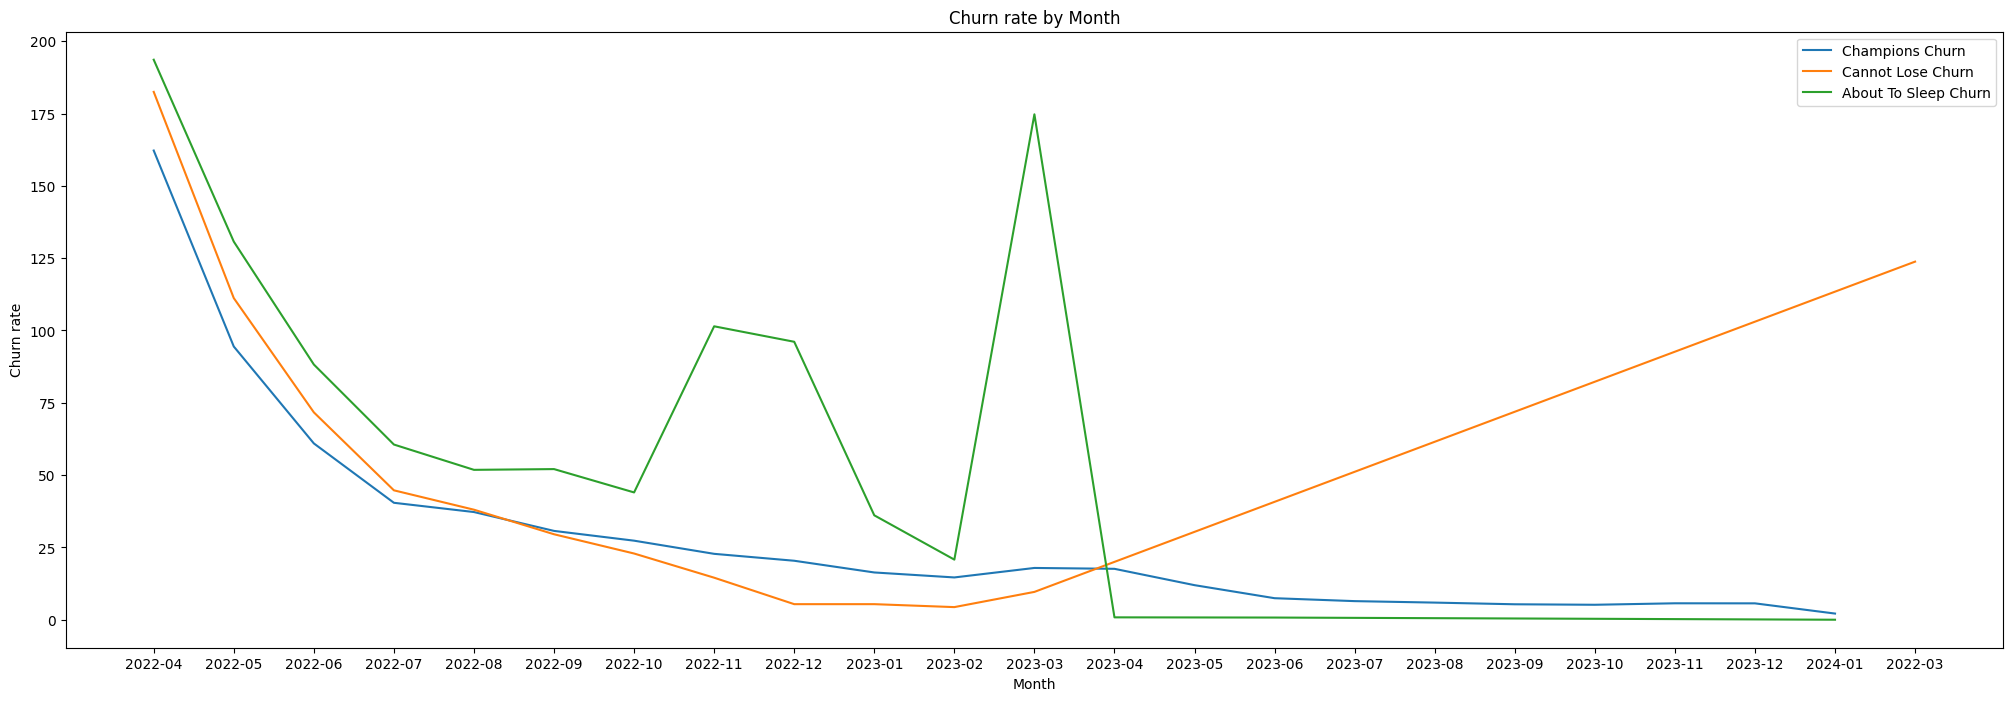

In [10]:
# Vẽ line chart biểu diễn cho cả 3 phân khúc khách hàng
plt.figure(figsize=(25,8))
sns.lineplot(data=champion_churn, x='month', y='Churn rate',label='Champions Churn', markers='o')
sns.lineplot(data=cannot_lose_churn, x='month', y='Churn rate',label='Cannot Lose Churn', markers='s')
sns.lineplot(data=about_to_sleep_churn, x='month', y='Churn rate',label='About To Sleep Churn', markers='s')
plt.title('Churn rate by Month')
plt.xlabel('Month')
plt.ylabel('Churn rate')
plt.show()

**NHẬN XÉT**:

- Các khách hàng thuộc phân khúc Champions có tỷ lệ rời bỏ dịch vụ giảm dần ở mức tương đối ổn định trong giai đoạn kinh doanh. Điều này cho thấy khách hàng trong phân khúc này rất trung thành và ít có xu hướng rời bỏ dịch vụ. Sự ổn định trong tỷ lệ churn cho thấy họ ít bị ảnh hưởng bởi các thay đổi nhỏ trong dịch vụ hoặc giá cả. Với tệp khách hàng tiềm năng này, các hoạt động marketing của công ty nên áp dụng những chương trình khách hàng thân thiết và thực hiện cá nhân hóa cho trải nghiệm của từng khách hàng thuộc phân khúc này để duy trì mối quan hệ lâu dài.

- Với những khách hàng thuộc phân khúc Cannot Lose Them, trước đó họ có lịch sử sử dụng ứng dụng thường xuyên và có số điểm tích lũy trên mức trung bình. Nhưng đến thời điểm tháng 03/2023, tỷ lệ rời bỏ dịch vụ của họ có xu hướng tăng cao, chứng tỏ họ không trở lại tiếp tục dùng ứng dụng. Vì thế, trong tương lai cần dự báo các thời điểm mà tỷ lệ rời bỏ của tệp khách hàng này tăng, từ đó phòng marketing cần có kế hoạch giữ chân họ bằng một số cách như tạo điều kiện tương tác với họ nhiều hơn, gia hạn các gói ưu đãi tích điểm,...

- Phân khúc khách hàng “About To Sleep” (đường màu xanh lá) có tỷ lệ rời bỏ dịch vụ khá ổn định và thấp từ tháng 01/2023 đến khoảng tháng 01/2024. Tuy nhiên, có một sự gia tăng đáng kể vào tháng 4/2021, sau đó giảm trở lại mức thấp và ổn định từ tháng 04/2023 trở đi, có thể do một sự kiện hoặc thay đổi nào đó ảnh hưởng đến hành vi của khách hàng.
Sự gia tăng đột ngột vào tháng 04/2023 cho thấy khách hàng trong phân khúc này có thể nhạy cảm với những thay đổi lớn hoặc sự kiện đặc biệt. Điều này có thể bao gồm thay đổi về giá cả, chất lượng dịch vụ, hoặc các yếu tố bên ngoài khác.Nếu không có sự kiện bất ngờ nào xảy ra, khách hàng trong phân khúc này có khả năng tiếp tục duy trì hành vi ổn định và ít rời bỏ dịch vụ.
Để tiếp tục duy trì và khai thác tệp khách hàng này, bộ phận marketing của công ty thực hiện các thông điệp nhắc nhở hoặc ưu đãi đặc biệt để khuyến khích khách hàng nâng cao tần suất sử dụng dịch vụ.